<a href="https://colab.research.google.com/github/fshivam/Banking_Project/blob/master/Banking_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

df = pd.read_csv('banking.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


## **About the dataset**



---

The data belongs to a Portuguese bank and relates to their telemarketing campaigns for fixed deposits. 

The goal is to use this dataset, in order to increase the subscription rate for their fixed deposits. 

---



### **Class Imbalance**



---

There are **36548** failed subscriptions and only **4640** successful subscriptions. This makes it difficult to develop a production level model without introducing some level of bias. 

---



In [3]:
# Checking for class imbalance
df_copy = df.copy()
print(df['y'].value_counts())

0    36548
1     4640
Name: y, dtype: int64


### **Duplicates**



---
There are 12 duplicates in the dataset, these should be dropped

---




In [4]:
# Check for duplicates
df_copy = df.copy()
print('Number of duplicates: {}'.format(len(df_copy[df_copy.duplicated()])))

# Removing duplicates
df = df_copy[~df_copy.duplicated()]

Number of duplicates: 12


### **Defaults**

---
There are only 3 people in the ~41K dataset that have defaults with the bank, and a substantial (8596) people given an "unknown" default status. 

In the light of this, it is better to drop the default column since it is not really contributing anything. 

---




In [5]:
# Verify and drop 'default' column
df_copy = df.copy()
print(df_copy['default'].value_counts())
df = df_copy.drop('default', axis=1)

no         32577
unknown     8596
yes            3
Name: default, dtype: int64


### **Negligible Contribution of Illiterates**



---

Similarly, illiterates (in the education column) contributes less than 1% to the total data, hence this category should be ignored for further analysis.

---



In [6]:
# Checking total datapoints for illiterates
df_copy = df.copy()
print(df_copy['education'].value_counts())
print('Contribution of illiterates to total data: {}%'.format(df_copy['education'].value_counts().iloc[-1]/len(df_copy) * 100))

university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: education, dtype: int64
Contribution of illiterates to total data: 0.043714785311832136%


## **Deep Dive!**



---

Let us take the route of trying to ask questions to the data, and see what comes up. 

We'll base the questions on our commonsense rather than on the specific domain of banking or telemarketing. 

---





### **Which age group is more likely to do a fixed deposit?**


In [7]:
# Bucketize age groups
df_copy = df.copy()
bins = [0, 30, 40, 50, 60, 100]
labels = [20, 30, 40, 50, 60]
df_copy['age_group'] = pd.cut(df_copy['age'], bins=bins, labels=labels)

In [8]:
count_age_response_pct = pd.crosstab(df_copy['y'], df_copy['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose() 

In [9]:
age = pd.DataFrame(df_copy['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_response_pct[1]
age.drop('age_group', axis = 1, inplace = True)
age['age'] = [30, 40, 20, 50, 60]
age = age.sort_values('age',ascending = True)

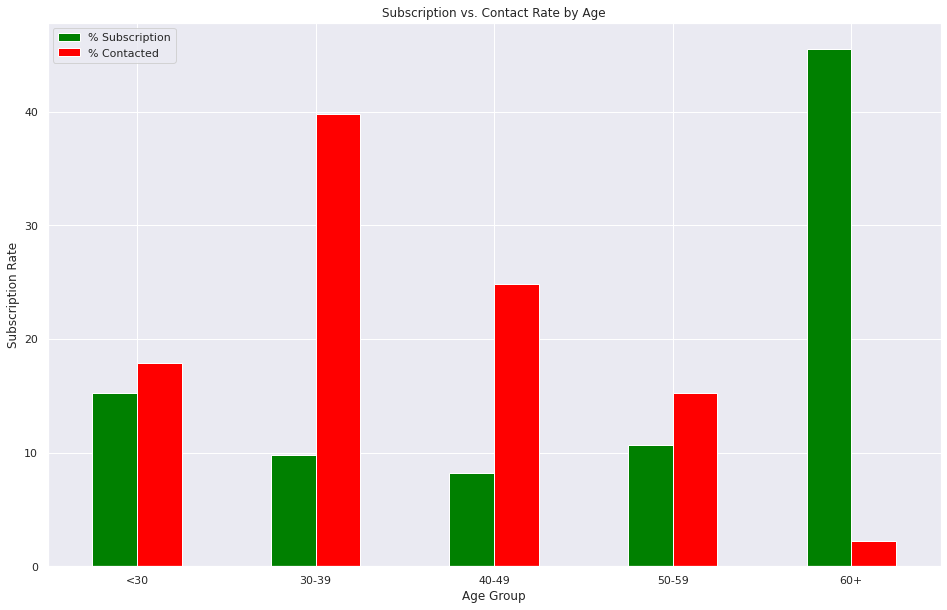

In [10]:
plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(16,10), color = ('green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

### **Insight: Age group less than 30 and more than 60+ should be targetted more!**

---

This may be due to age groups in the middle consist primariliy of working classes so it would make more sense for them to take invest in riskier options (like mutual funds or other riskier securities)

Whereas students and retired people would want to stay risk averse at this point in their life and the safety of an FD is alluring

---




### **Which specific cateogry should we focus more on?**


In [11]:
df_copy = df.copy()
count_job_response_pct = pd.crosstab(df_copy['y'], df_copy['job']).apply(lambda x: x/x.sum() * 100)
count_job_response_pct = count_job_response_pct.transpose()

Text(0, 0.5, 'Job Category')

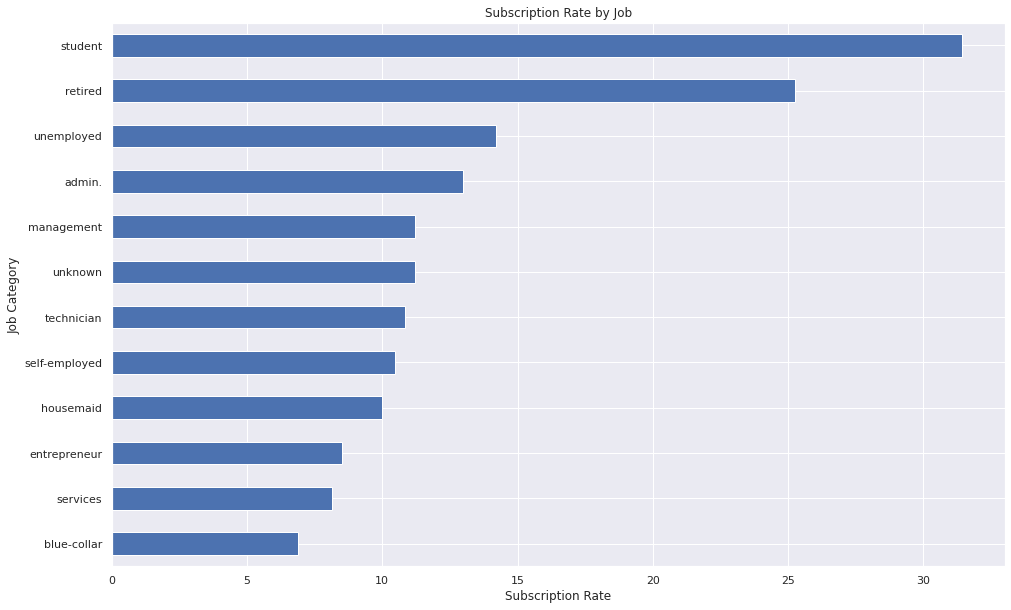

In [12]:
plot_job = count_job_response_pct[1].sort_values(ascending = True).plot(kind ='barh', figsize = (16,10))
plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')                                              

### **Insight: Student and Retired categories have by far the highest subscription rates.**



---

This also confirms our previous hypothesis about targetting age groups below 30 and above 60 since below customers below are mostly students or starting out fresh as employees and customers above 60 are retired. 

---



### **How often should we call our customers?**

In [13]:
df_copy = df.copy()
bins = [0, 1, 3, 5, 15, 30, 10000]
labels = ['Only 1', 'Upto 3', 'Upto 5', 'Upto 15', 'Upto 30', 'More than 30']
df_copy['campaign_cat'] = pd.cut(df_copy['campaign'], bins=bins, labels=labels)

In [14]:
pd.crosstab(df_copy['campaign_cat'], df_copy['y'])

y,0,1
campaign_cat,,
Only 1,15335,2299
Upto 3,14123,1785
Upto 5,3880,369
Upto 15,2849,181
Upto 30,317,5
More than 30,33,0


In [15]:
campaigns = pd.DataFrame()
campaigns['Number of calls'] = labels
campaigns['Subscription Rate'] = pd.crosstab(df_copy['campaign_cat'], df_copy['y']).apply(lambda x: x/x.sum(), axis=1).iloc[:,1].to_list()

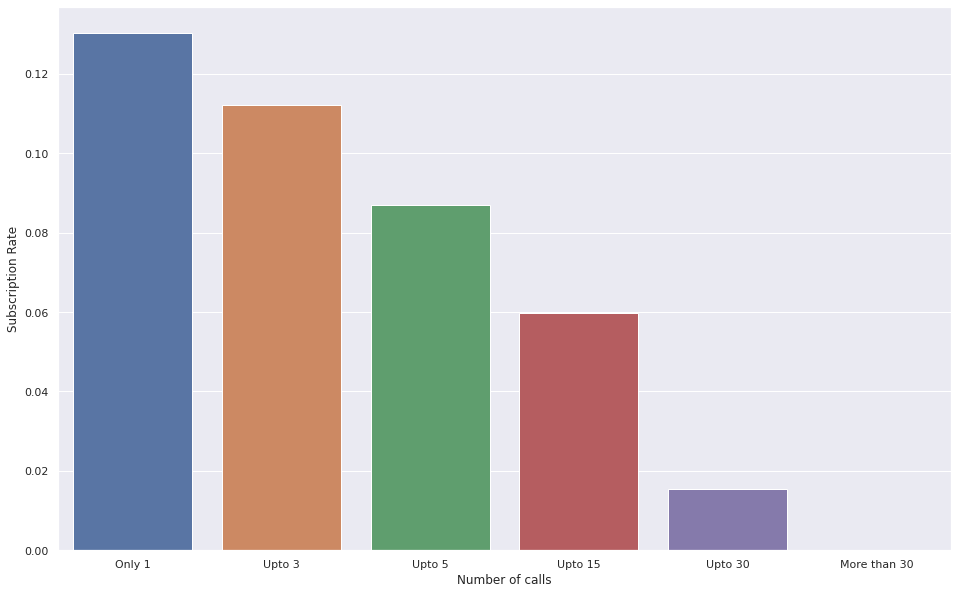

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(campaigns['Number of calls'], campaigns['Subscription Rate'])
plt.show()

### **Insight: An inverse relationship exists between the subscription rate and the number of calls made to a customer.**

---

Perhaps the reason for this is that after a point marketing calls can get annoying or feel intrusive. A hard threshold for the maximum number of calls should be 30. This is evident from the fact that the bank called 33 customers more than 30 times, out of which no client took the subscription of a fixed deposit at the bank.

---



### **How long should the call optimally be?**


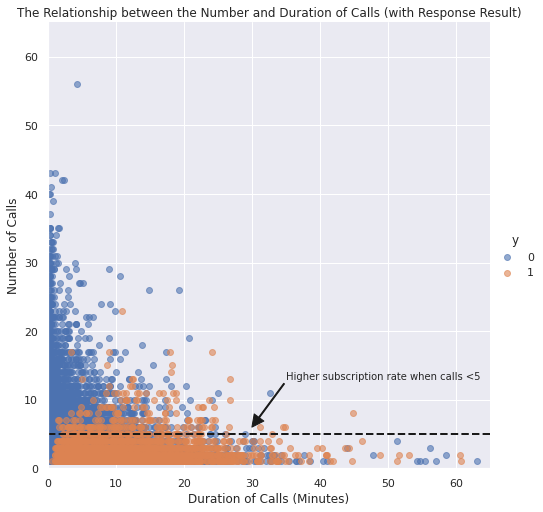

In [17]:
df_copy = df.copy()
df_copy['duration'] = df_copy['duration'].apply(lambda n:n/60).round(2)


dur_cam = sns.lmplot(x='duration', y='campaign',data = df_copy,
                     hue = 'y',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))
plt.show()

### **Insight: The bank should resist calling a client for more than five times!**


---

We see two distinct clusters.

The clients that ended up subscribing were contacted fewer times and were spoken to for a relatively longer duration as compared to clients that failed to convert who were very frequently contacted. More importantly, most of the clients that converted were approached less than 10 times.


---



### **Is the subscription rate seasonal?**

In [18]:
df_copy = df.copy()

count_month_response_pct = pd.crosstab(df_copy['y'], df_copy['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()

month = pd.DataFrame(df_copy['month'].value_counts())
month['% Contacted'] = month['month']*100/month['month'].sum()
month['% Subscription'] = count_month_response_pct[1]
month.drop('month', axis = 1,inplace = True)

In [19]:
month

,% Contacted,% Subscription
may,33.434525,6.435680
jul,17.410628,9.038918
aug,14.999029,10.605570
jun,12.915290,10.511470
nov,9.957257,10.146341
apr,6.389644,20.486507
oct,1.741306,43.933054
sep,1.384302,44.912281
mar,1.326015,50.549451
dec,0.442005,48.901099


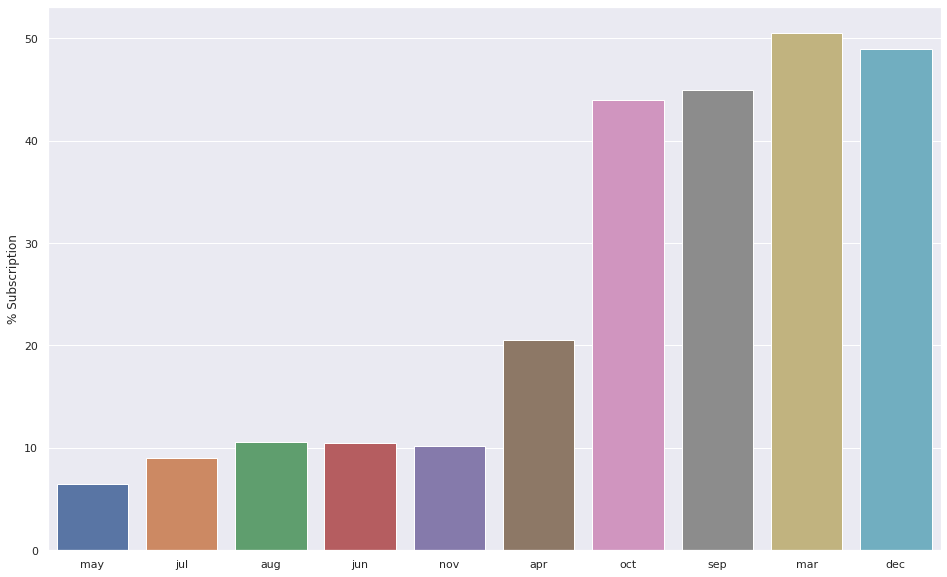

In [20]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(month.index, month['% Subscription'])
plt.show()

### **Insight: April, March, September, October, December are the months where there is a significantly higher subscription rate relative to our contact rate**



---
April and May closely correspond to summer break months where maybe students are working on internships and are more keen to invest the money they have earned. The same goes for the winter break in December. 

Perhaps in these months we should target students and retired people as we have noted earlier. 

It is also worth noting that heavy efforts are being spent in May and July but the conversion rate is not encourgaing. 

The bank should shift their attention to the clearly more optimal months. 

---



References:

1. https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
2. S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014
3. S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimaraes, Portugal, October, 2011. EUROSIS.
4. https://www.kaggle.com/yufengsui/ml-project-bank-telemarketing-analysis 